This is the original script I wrote to process the data set. In this instance, it will only create functions to do the work, but will not actually execute on its own.

In [8]:
import pandas as pd
import datetime

# load up the weather csv into a pandas dataframe
def Load_Weather():
    data = pd.read_csv('weather.csv', parse_dates=['DATE'])
    data['DATE_left'] = data['DATE']
    return(data)

# grab the average daily value reports and take the columns with the most 
# relevant data
def Trim_Weather(data):
    # grab the SOD reports for DAILY Averages
    data = data[data.REPORTTPYE == 'SOD']

    # trim some columns
    data = data[['DATE','DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
                 'DAILYAverageDryBulbTemp',
                 'DAILYSunrise', 'DAILYSunset', 'DAILYPrecip']]
    
    data['DATE'] = data['DATE'].dt.normalize()
    return(data)    
    
# load the crime data
def Load_Crime():
    data = pd.read_csv('Crimes_-_2001_to_present.csv', index_col='Date')
    return(data)

def Trim_Crime(data):
    data.index = pd.to_datetime(data.index)
    data['DATE'] = data.index
    data = data[data['DATE'] >= datetime.date(2008,1,1)]
    data = data[data['DATE'] <= datetime.date(2017,11,25)]
    data['DATE'] = data['DATE'].dt.normalize()
    data['DATE_right'] = data['DATE']
    return(data)

def Process_Data():    
# main
    chicago_weather = Load_Weather()
    chicago_weather = Trim_Weather(chicago_weather)
    desc = chicago_weather.describe(include='all')
    
    print(desc)
    
    chicago_crimes = Load_Crime()
    cdesc = chicago_crimes.describe(include='all')
    print(cdesc)
    
    chicago_crimes = Trim_Crime(chicago_crimes)
    cdesc = chicago_crimes.describe(include='all')
    print(cdesc)
    
    chicago_data = chicago_weather.join(chicago_crimes, on='DATE', how='outer',
                                        lsuffix='_left', rsuffix='_right')

    return(chicago_data)

This next block simply runs the method which bootstraps the data load. It is simple, but will take quite some time to run!

In [9]:
chicago_data = Process_Data()

/Users/davidmadsen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,20,22,23,25,26,27,28,29,33,34,38,40,44,45,46,47,63,64,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


                       DATE DAILYMaximumDryBulbTemp  DAILYMinimumDryBulbTemp  \
count                  3616                    3614                   3614.0   
unique                 3616                     208                    189.0   
top     2015-10-18 00:00:00                      82                     65.0   
freq                      1                      62                     57.0   
first   2008-01-01 00:00:00                     NaN                      NaN   
last    2017-11-25 00:00:00                     NaN                      NaN   
mean                    NaN                     NaN                      NaN   
std                     NaN                     NaN                      NaN   
min                     NaN                     NaN                      NaN   
25%                     NaN                     NaN                      NaN   
50%                     NaN                     NaN                      NaN   
75%                     NaN             

/Users/davidmadsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
/Users/davidmadsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


                  ID Case Number             Block     IUCR Primary Type  \
count   3.236209e+06     3236205           3236209  3236209      3236209   
unique           NaN     3235958             34446      386           33   
top              NaN    HZ140230  001XX N STATE ST     0486        THEFT   
freq             NaN           6              6560   281632       706641   
first            NaN         NaN               NaN      NaN          NaN   
last             NaN         NaN               NaN      NaN          NaN   
mean    8.570342e+06         NaN               NaN      NaN          NaN   
std     1.530342e+06         NaN               NaN      NaN          NaN   
min     4.379000e+03         NaN               NaN      NaN          NaN   
25%     7.288908e+06         NaN               NaN      NaN          NaN   
50%     8.551642e+06         NaN               NaN      NaN          NaN   
75%     9.866212e+06         NaN               NaN      NaN          NaN   
max     1.17

Now let's look at the primary types of crime. We first extract jus the dates and primary types for each entry. We then group the data and look at the total sizes to get counts of each type of crime by date. Finally, we make a top 10 list with the totals.

In [11]:
primary_crimes = chicago_data[['DATE', 'Primary Type']]
primary_totals = primary_crimes.groupby('Primary Type').size().reset_index()

primary_top = primary_totals.sort_values(0, ascending = False).head(10)
primary_top

,Primary Type,0
31,THEFT,706641
2,BATTERY,576836
6,CRIMINAL DAMAGE,359106
17,NARCOTICS,318666
3,BURGLARY,200613
1,ASSAULT,198444
24,OTHER OFFENSE,197335
8,DECEPTIVE PRACTICE,149113
16,MOTOR VEHICLE THEFT,143289
28,ROBBERY,128209


In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Now that matplotlib is available to us, we want to make sure the dataset is in good shape to look at time series plots of the various types of crime.

In [48]:
primary_by_date = primary_crimes.groupby(['DATE', 'Primary Type']).size().reset_index()
primary_by_date.head()

,DATE,Primary Type,0
0,2008-01-01,BATTERY,1
1,2008-01-01,BURGLARY,2
2,2008-01-01,CRIM SEXUAL ASSAULT,5
3,2008-01-01,CRIMINAL DAMAGE,5
4,2008-01-01,DECEPTIVE PRACTICE,13


This will create the time series plots for each of the top 10 primary crime types. Note the peaks and valleys. Seperate plots are used due to the domination of the 'THEFT' type over the others.

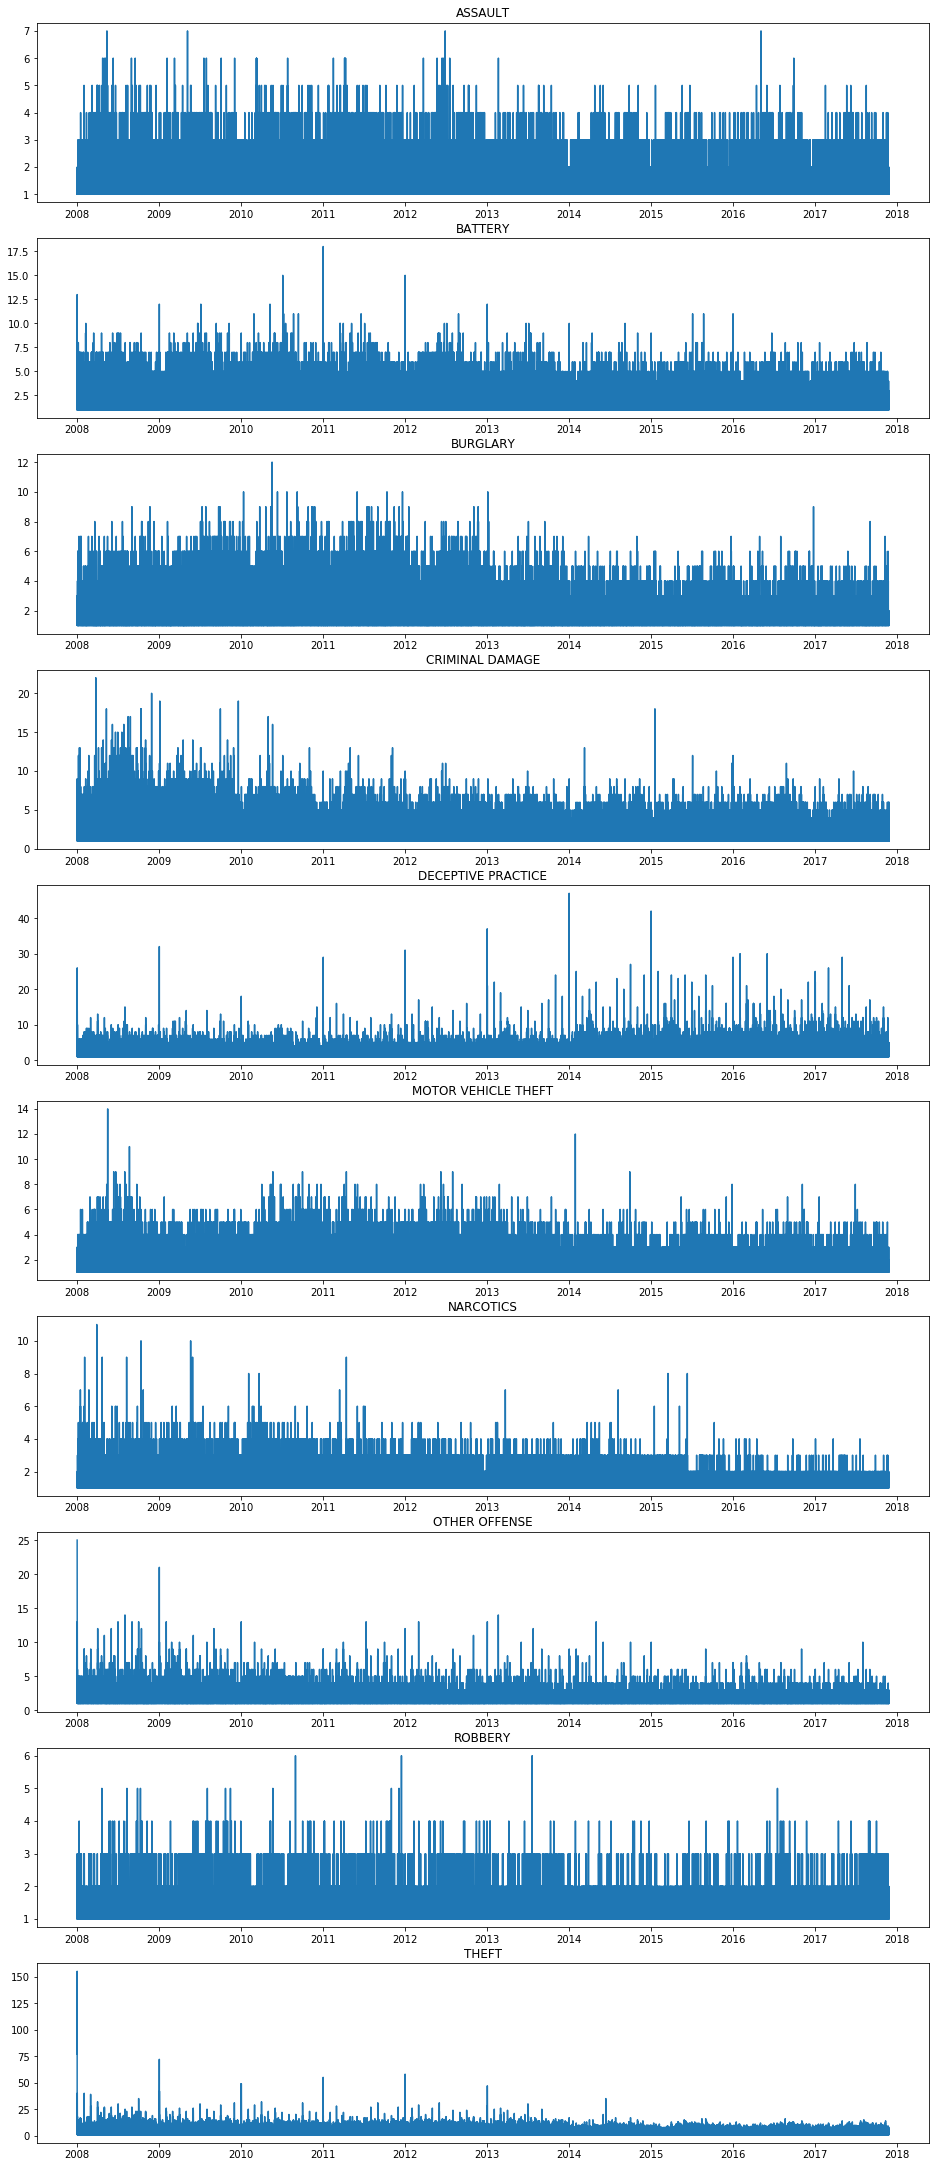

In [52]:
plt.figure(figsize=(16,39))
# this counter will be used to walk through our grid of subplots
i = 0
for key, group in primary_by_date.groupby('Primary Type'):
    if key in pd.unique(primary_top['Primary Type']):
        i = i+1
        # subplot (grid rows, grid columns, grid position)
        plt.subplot(10,1,i)
        plt.plot(group['DATE'], group[0])
        plt.title(key)
plt.show()

This is a bit of a dance to create a subset of the data aggregated by month and year for Primary crime types.

In [38]:
pc2 = primary_crimes.set_index('DATE')

In [78]:
pc3 = pc2.groupby(by=[pc2.index.month, pc2.index.year, 'Primary Type']).size()
pc3.index.names = ['Month', 'Year', 'Primary Type']
pc3 = pc3.reset_index()

In [86]:
pc4 = pc3.groupby(['Month', 'Primary Type']).mean().reset_index()

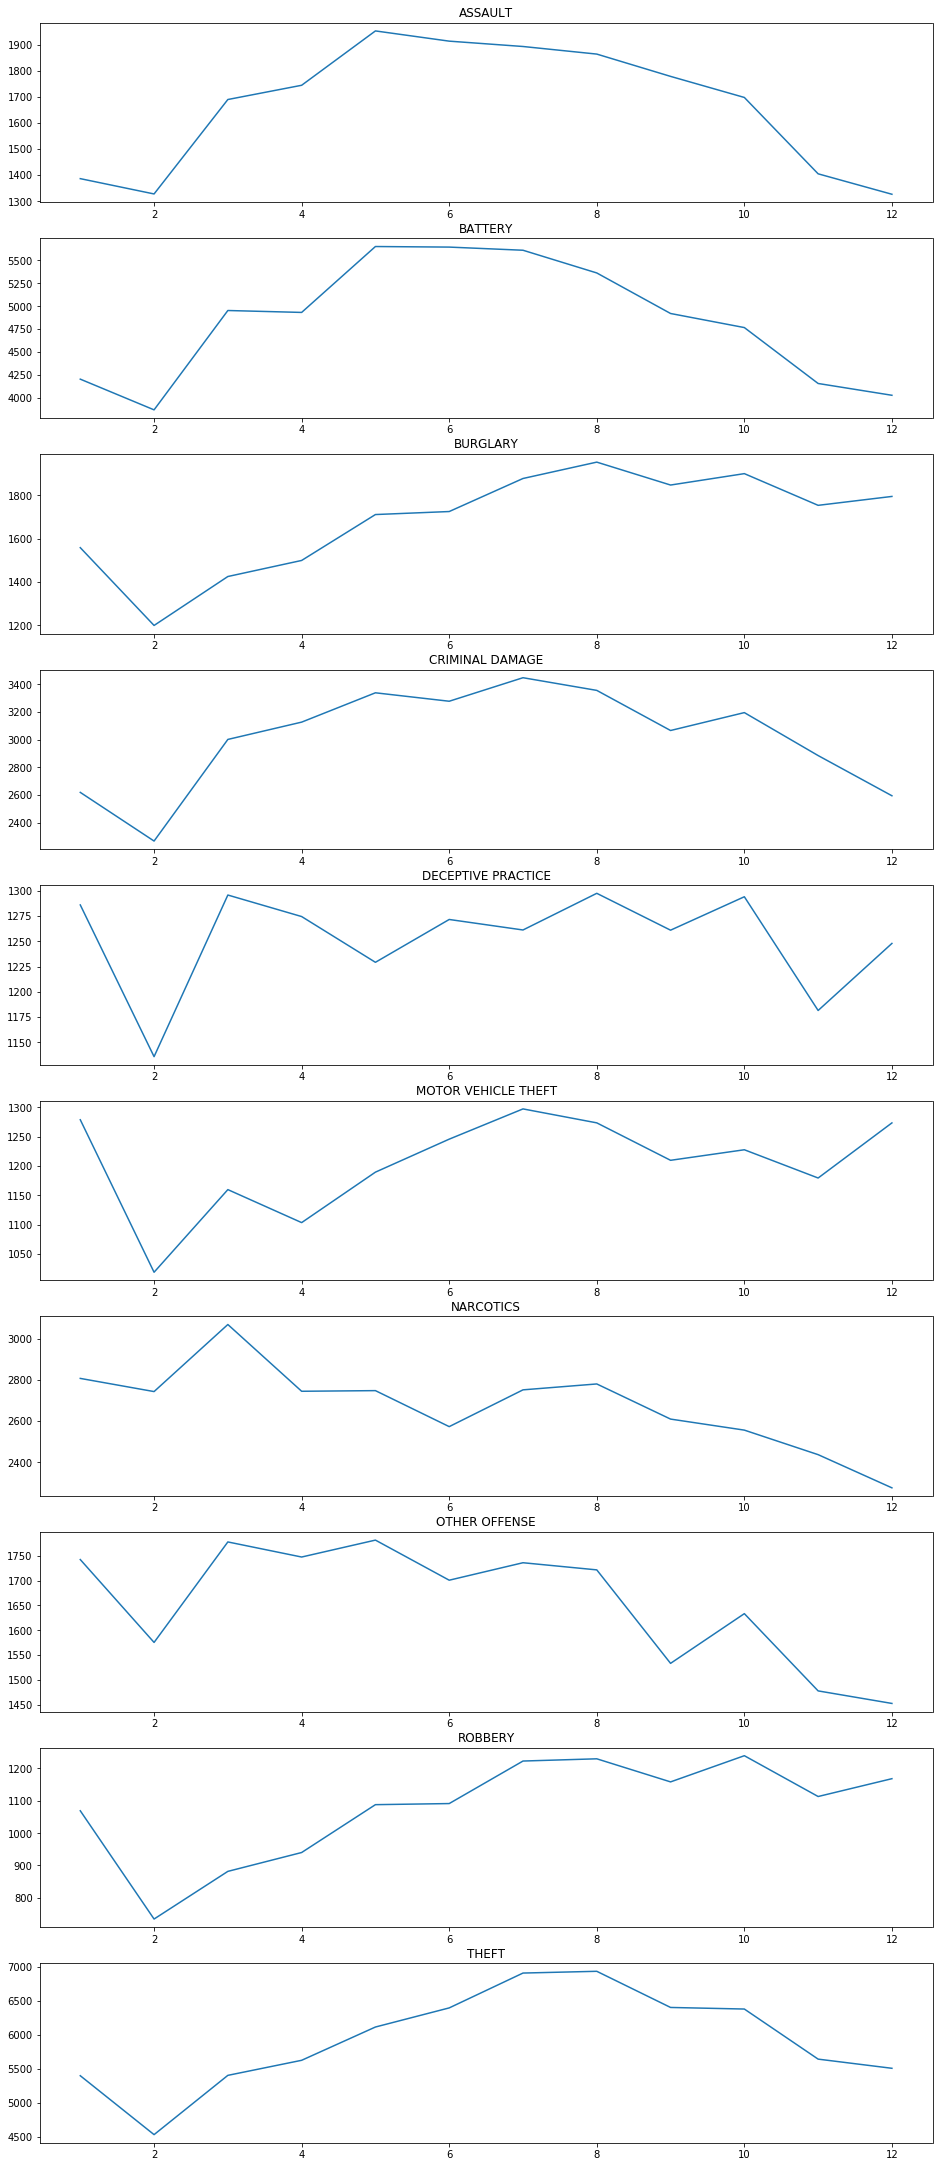

In [99]:
fig = plt.figure(figsize=(16,39))
i = 0
for key, group in pc4.groupby('Primary Type'):
    if key in pd.unique(primary_top['Primary Type']):
        i = i+1
        plt.subplot(10,1,i)
        plt.plot(group['Month'], group[0])
        plt.title(key)    
plt.show()

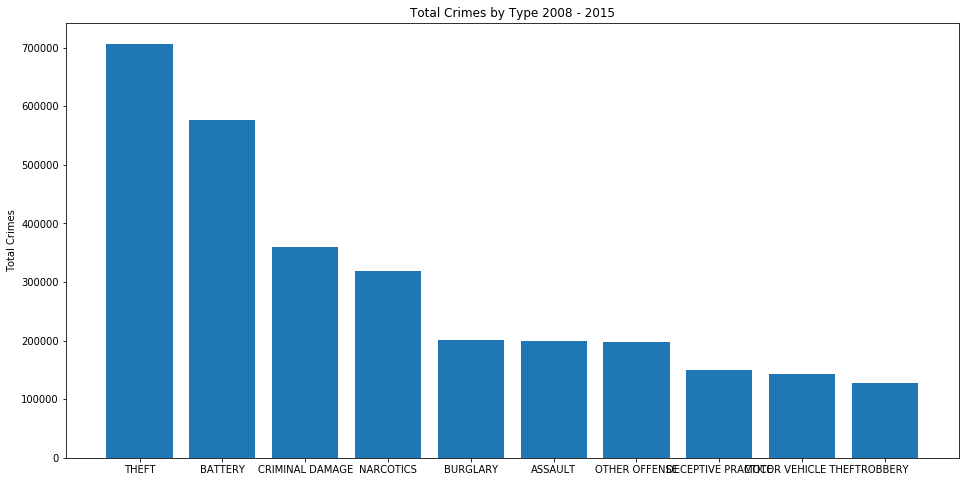

In [101]:
import numpy as np
plt.figure(figsize = (16,8))
y_pos = np.arange(10)
plt.bar(y_pos, primary_top[0], align='center')
plt.xticks(y_pos, primary_top['Primary Type'])
plt.ylabel('Total Crimes')
plt.title('Total Crimes by Type 2008 - 2015')
plt.show()

While the subplots are nice when data is overlapping to give a comparison view, when the overlap is manageable or doesn't exist, we can combine the plots to a single view.

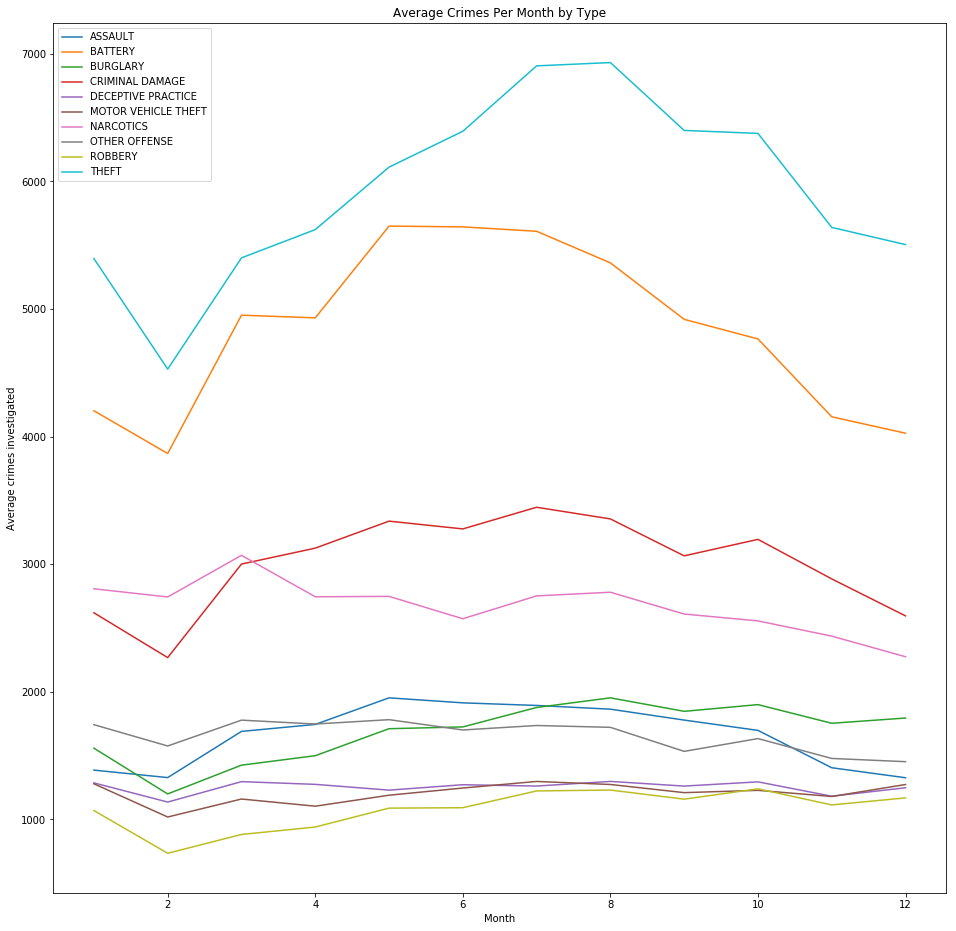

In [100]:
plt.figure(figsize=(16,16))

for key, group in pc4.groupby('Primary Type'):
    if key in pd.unique(primary_top['Primary Type']):
        plt.plot(group['Month'], group[0], label = key)

plt.xlabel("Month")
plt.ylabel("Average crimes investigated")
plt.legend()
plt.title("Average Crimes Per Month by Type")
plt.show()